# Multiphase Classifier: Sample Notebook

## Part 0: Setup

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from classifier_utils import utils, example_boundaries

In [2]:
import matplotlib.colors as mcolors

# Species colors
node_pink = '#ef559f'
node_green = '#3ab261'
node_colors = [node_pink, node_green, '#efa873','#8bcbca']

decision_pink ='#f6accc'
decision_green = '#b0dbb8'

# Colorbar colors
cb_colors = ['#e7298a', '#34ac5c']
color1 = cb_colors[0] # Start color
color2 = cb_colors[1] # End color

# Create a custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [color1, "white", color2])

## Part 1: Mean-Field Forward Simulations

First, we'll explore how to run a forward simulation of the model A dynamics of a system governed by a Flory-Huggins free energy. We start by setting the number of input, output and hidden species in the system.

In [3]:
n_inputs, n_outputs, n_hidden = [2, 2, 4] # the number of input, output and hidden species
n_components = n_inputs + n_outputs + n_hidden

Next, we need an interaction network between the particle species. In particular, we don't want interactions so strong that they would correspond to solid phases in 3D models, so we set `max_chi=15`. We also want different output species to be repulsive, so we set the minimum possible output-output interaction to be `min_out_chi=10`.

In [4]:
max_chi = 15 # maximum possible absolute value for entries in the chi matrix 
min_out_chi = 10 # minimum possible output-output value in the chi matrix

We set the matrix `chimat` by generating a random vector that is then passed to a formatting function `chivec_to_chimat` to turn it into a properly formatted matrix.

We then generate another random vector for the chemical potential of the reservoir with which the system exchanges.

In [5]:
key = jax.random.PRNGKey(0)
key, split = jax.random.split(key)

# Initialize a random interacton matrix:

n_exclude = n_inputs
n_include = n_components - n_exclude
vec_len = int(n_include*n_exclude + n_include*(n_include - 1)/2)
chi = jax.random.uniform(split, (1,vec_len), minval = -1., maxval = 1.)[0]

chimat = utils.chivec_to_chimat(chi, min_out_chi, max_chi, n_inputs, n_outputs, n_hidden)

# Initialize a random chemical potential vector:

key, split = jax.random.split(key)
mu_res = jax.random.uniform(split, (1,n_components-n_inputs), minval = -5., maxval = 0.)[0]

chimat.shape, mu_res.shape

((8, 8), (6,))

We can now run a simulation under Model A dynamics using the `fh_utils` module:

In [6]:
from fh_utils import model_A_dynamics

diffrax_integrate = model_A_dynamics.get_integrator(illustrate=True) # Initialize integrator

phi_in = jnp.array([0.08, 0.13]) # set fixed input concentrations
phi_out_and_hidden = 0.001*jnp.ones(n_outputs+n_hidden) # set initial output and hidden concentrations

#----------Import Parameters and Run Simulation----------#

_, (stats, t_vals, _, phi_aux) = diffrax_integrate(phi_out_and_hidden, phi_in, chimat[n_inputs:], mu_res)

Plotting the evolution of each output and hidden species, we see different recruitments of the two output species that also correlate closely with the dynamics of the hidden species. The goal of the next section is to tune the properties of the system to be able to target desired responses (i.e. the enrichment of one output species vs another) to different sets of input concentrations.

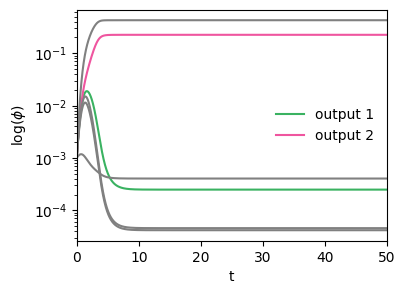

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))

ax.plot(t_vals, phi_aux[:,0], color=node_green, label='output 1')
ax.plot(t_vals, phi_aux[:,1], color=node_pink, label='output 2')
ax.plot(t_vals, phi_aux[:,2:], color='gray')
ax.set_xlim(0,50)
ax.set_yscale('log')
ax.set_xlabel('t')
ax.set_ylabel(r'$\log(\phi)$')
ax.legend(frameon=False)

plt.show()

## Part 2: Classifier Optimization

In the remainder of the notebook, we provide an example of how a multiphase classifier is trained to solve a simple 2-dimensional decision boundary. Here, we'll use an AND decision boundary, but the same library of functions can be used to construct a multiphase classifier for any set of training and test data.

In [8]:
boundary_type = "and" # decision boundary

### Step 1: Set System Conditions

First, we introduce a training dataset. With the simple boundary we have chosen, we can use functions in `example_boundaries.py` to construct this dataset.

Encoding the training data as a set of concentrations requires the definition of a `max_input`, which corresponds to the maximum volume fraction that any one input species can occupy in the system. We take this value to be `max_input=0.5/n_inputs`, where n_inputs is the number of input species in our problem (in our case, 2).

In [9]:
max_input = 0.25

We'll generate 5000 training points:

In [10]:
# Generate training data
training_data, training_indices = example_boundaries.get_dataset_2D(boundary_type, max_input, dataset_length=5000, seed=2)

Next, we define the number of hidden species to be used in building the classifier. In this example, we'll use 4.

In [11]:
n_hidden = 4 # number of hidden species to introduce into the system
sizes = (2, 2, n_hidden) # of the form (n_inputs, n_outputs, n_hiden)

Finally, we must define the remaining parameters relevant to the optimization.

In [12]:
learning_rate = 0.01 # learning rate for the optimization
opt_steps = 1000 # number of optimization epochs

### Step 2: Train the classifier

We are ready to train the classifier. For this, we simply need to pass the data and constants defined above.

In [13]:
from classifier_utils import train

/Users/azentner/anaconda3/envs/multiphase-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
sol_opt, aux = train.run(seed = 2,
                         training_data = training_data,
                         training_indices = training_indices,
                         n_hidden = n_hidden,
                         learning_rate = learning_rate,
                         opt_steps = opt_steps,
                         batch_length = 64)

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:36<00:00, 27.76it/s]


In [15]:
loss_vals = aux[-1]

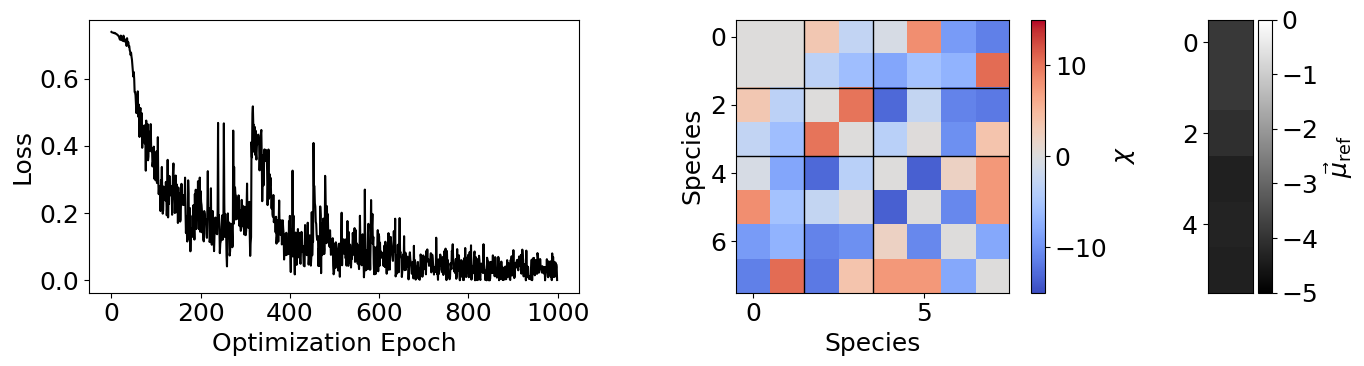

In [16]:
from gen_utils import plot_gen

fig = plot_gen.plot_loss_and_outputs(loss_vals, sol_opt, sizes)

### Step 3: Test the classifier

In [17]:
# Generate test data
test_data, test_indices = example_boundaries.get_dataset_2D(boundary_type, max_input, dataset_length=500, seed=3)

In [18]:
from classifier_utils import test

test_results = test.run(*sol_opt, test_data, test_indices, sizes)

phi_test_final = test_results[1]
indices_pred = test_results[3]

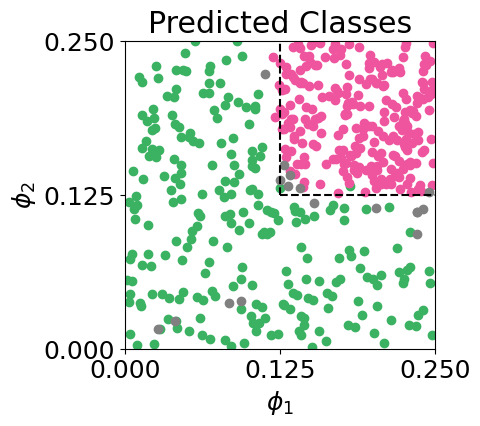

In [19]:
from gen_utils import plot_gen

fig = plot_gen.plot_classifier_guesses(phi_test_final[:,:2], indices_pred, boundary_type, max_input)